# 1. Prepare plotting scripts

In [33]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [34]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [35]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            final_layer = layers[-1]
            return final_layer
            break

In [36]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            return layers
            break

In [37]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split(",")[-1].split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [38]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            passage_identifier = get_passage_identifier(filename)
            condition = filename.split(",")[-1].split("-")[-2]
        
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]
        
            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary
        

In [39]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        scr1.append(value['Scr1'].values)
        scr3.append(value['Scr3'].values)
        scr5.append(value['Scr5'].values)
        scr7.append(value['Scr7'].values)
        lowpmi.append(value['lowPMI'].values)
        backward.append(value['backward'].values)
        random.append(value['random'].values)
        
    #print(np.shape(original))
    return original,scr1,scr3,scr5,scr7,lowpmi,backward,random

In [40]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [41]:
def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                              'Scr1':np.asarray(flatten_array(scr1)).flatten(),
                              'Scr3':np.asarray(flatten_array(scr3)).flatten(),
                              'Scr5':np.asarray(flatten_array(scr5)).flatten(),
                              'Scr7':np.asarray(flatten_array(scr7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random':np.asarray(flatten_array(random)).flatten()})
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'Original':flatten_array(original),
              'Scr1':flatten_array(scr1),
              'Scr3':flatten_array(scr3),
              'Scr5':flatten_array(scr5),
              'Scr7':flatten_array(scr7),
              'lowpmi':flatten_array(lowpmi),
              'backward':flatten_array(backward),
              'random':flatten_array(random)}
    return df

In [42]:
def main_df_for_plotting(model_identifier, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict), flatten=flatten) #*flattens the tuple
    return df

_____________________________________________________
_____________________________________________________

# Ready to plot!

# 1. Plot ClusterGrids for final layer

In [43]:
df_distilgpt2 = main_df_for_plotting("distilgpt2")

  4%|▍         | 174/4368 [00:00<00:02, 1681.53it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 4368/4368 [00:18<00:00, 235.55it/s]


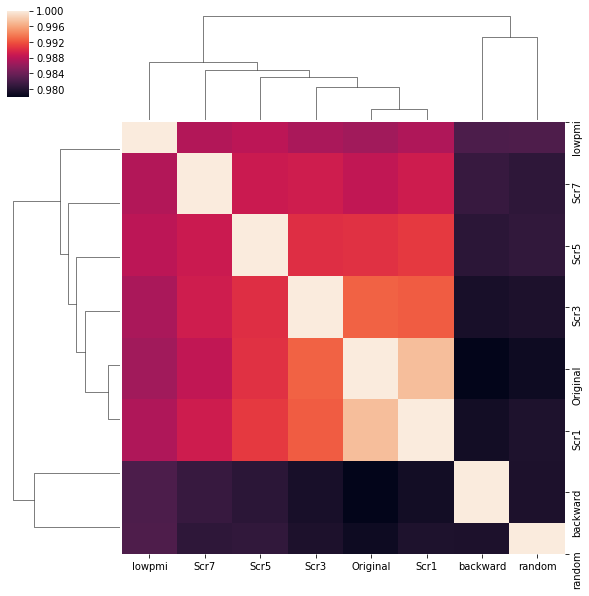

In [44]:
#sns.heatmap(df.corr())
#sns.heatmap(df.corr(method='spearman'))
sns.clustermap(df_distilgpt2.corr())

 66%|██████▌   | 2865/4368 [00:00<00:00, 27194.14it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 4368/4368 [00:13<00:00, 313.64it/s]  


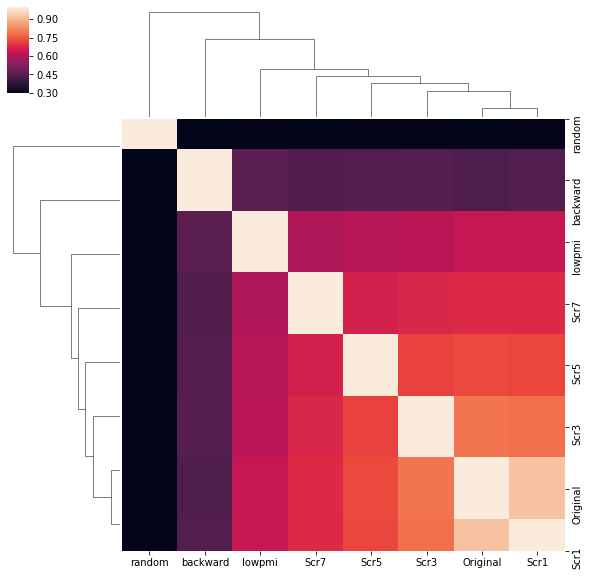

In [45]:
df_lm1b = main_df_for_plotting("lm_1b")
sns.clustermap(df_lm1b.corr())

 35%|███▍      | 1524/4368 [00:00<00:00, 14900.22it/s]

This is the layer I'm looking at:  projection


100%|██████████| 4368/4368 [00:11<00:00, 390.29it/s]  


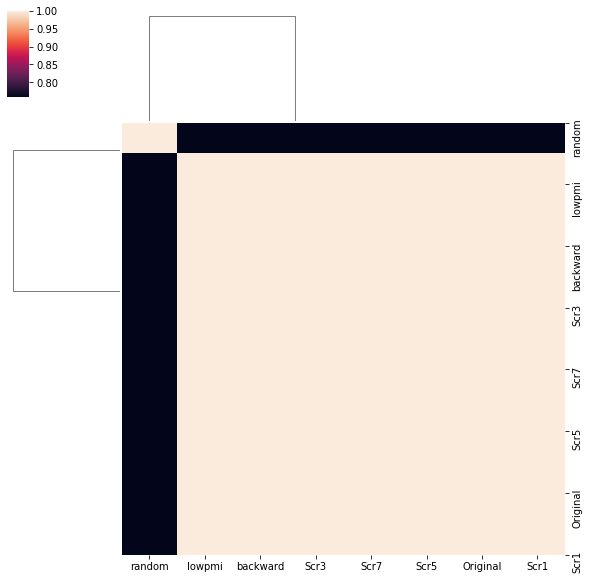

In [46]:
df_glove = main_df_for_plotting("glove")
sns.clustermap(df_glove.corr())

# 2. Look at different layers

In [47]:
df_lm1b_encoderh0 = main_df_for_plotting("distilgpt2",layer_identifier="encoder.h.0")

  4%|▍         | 176/4368 [00:00<00:02, 1721.50it/s]

This is the layer I'm looking at:  encoder.h.0


100%|██████████| 4368/4368 [00:16<00:00, 262.06it/s]


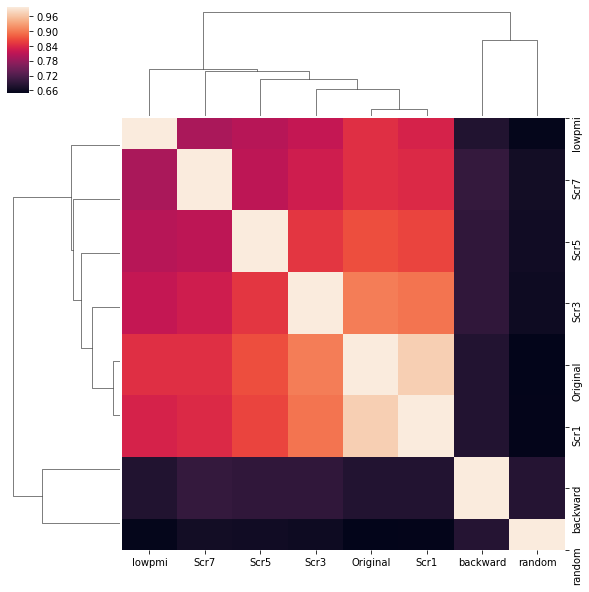

In [48]:
sns.clustermap(df_lm1b_encoderh0.corr())

In [49]:
def get_correlation_dfs_for_all_layers(model_identifier, flatten=True):
    layers = get_all_layers(model_identifier)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm,flatten=flatten)
    return df_dict

# 2.b Try looping through layers and put into subplots

### Caveat: Can't do ClusterGrid, as the graph cannot take ax as input. Look into how to do this if we want to

In [50]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")

 35%|███▍      | 1526/4368 [00:00<00:00, 14879.47it/s]

This is the layer I'm looking at:  projection


100%|██████████| 4368/4368 [00:09<00:00, 461.36it/s]  


In [51]:
print(len(glove_correlation_dict))

1


In [52]:
lm1b_correlation_dict = get_correlation_dfs_for_all_layers("lm_1b")

 66%|██████▌   | 2867/4368 [00:00<00:00, 27471.12it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 66%|██████▌   | 2868/4368 [00:00<00:00, 26955.07it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 4368/4368 [00:11<00:00, 377.39it/s]  


In [53]:
print(len(lm1b_correlation_dict))

2


In [54]:
import math
import matplotlib.pyplot as plt

def get_subplots(dictionary,model_name):
    number_subplots = len(dictionary)
    number_rows = math.ceil(number_subplots/2)
    
    fig, ax = plt.subplots(number_rows,2, figsize=(15, 7*number_rows))
    ax = ax.flatten()
    fig.suptitle(model_name, fontsize=26)
    
    counter = 0
    for key, value in dictionary.items():
        ax[counter] = sns.heatmap(value.corr(), ax=ax[counter], square=True)
        ax[counter].set_title(key, fontsize=16)
        bottom, top = ax[counter].get_ylim()
        ax[counter].set_ylim(bottom + 0.5, top - 0.5)
        counter += 1
    if number_subplots%2 == 1:
        fig.delaxes(ax[counter])

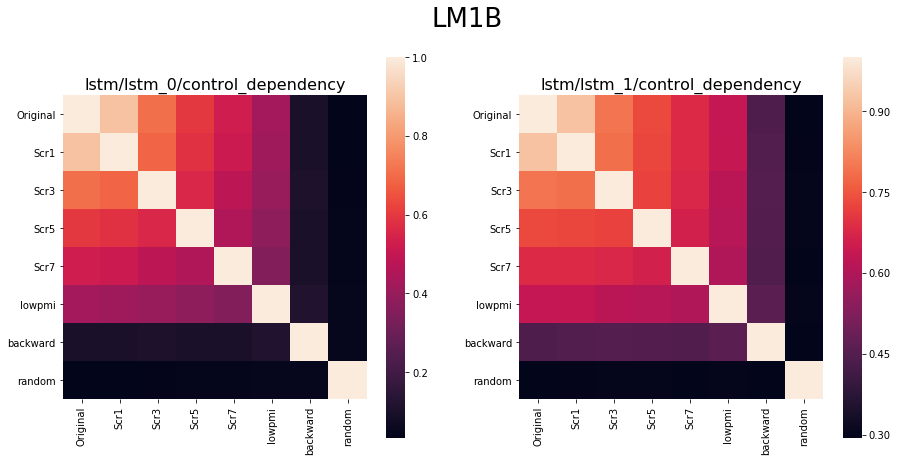

In [55]:
get_subplots(lm1b_correlation_dict, "LM1B")

# DistilGPT2

In [56]:
distilgpt2_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2")

  4%|▍         | 178/4368 [00:00<00:02, 1734.66it/s]

This is the layer I'm looking at:  drop


  4%|▍         | 178/4368 [00:00<00:02, 1725.27it/s]

This is the layer I'm looking at:  encoder.h.0


  4%|▍         | 178/4368 [00:00<00:02, 1688.26it/s]

This is the layer I'm looking at:  encoder.h.1


  4%|▍         | 178/4368 [00:00<00:02, 1759.61it/s]

This is the layer I'm looking at:  encoder.h.2


  4%|▍         | 179/4368 [00:00<00:02, 1638.00it/s]

This is the layer I'm looking at:  encoder.h.3


  4%|▍         | 178/4368 [00:00<00:02, 1775.65it/s]

This is the layer I'm looking at:  encoder.h.4


  4%|▍         | 178/4368 [00:00<00:02, 1693.79it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 4368/4368 [00:14<00:00, 296.40it/s]


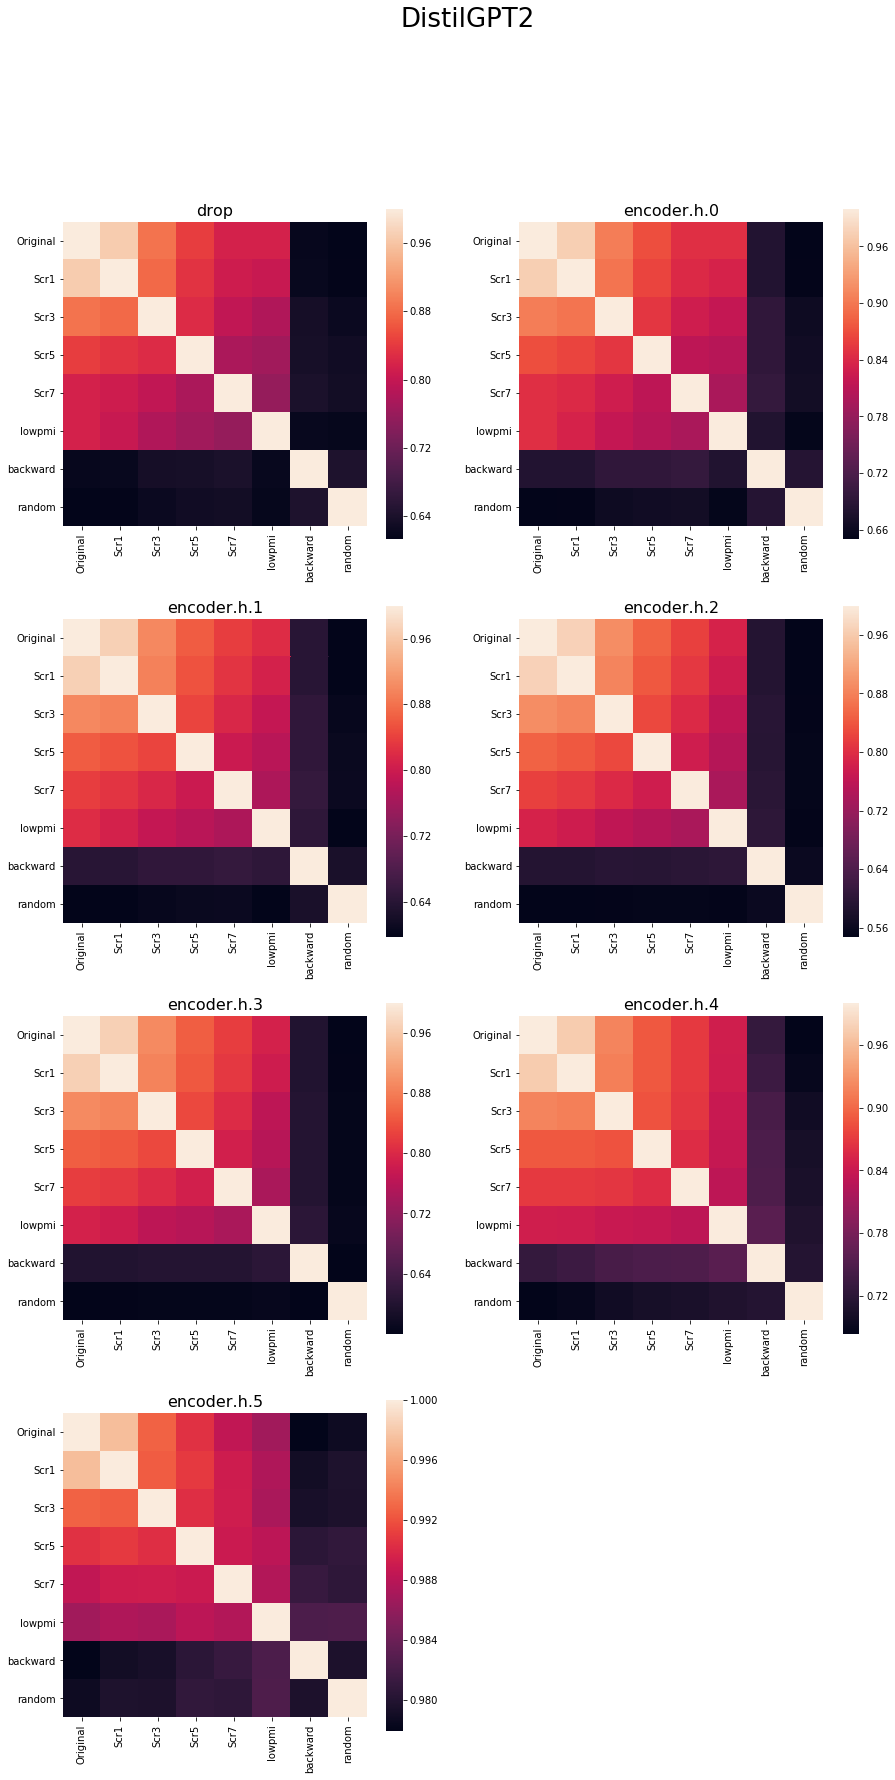

In [57]:
get_subplots(distilgpt2_correlation_dict, "DistilGPT2")

### Glove

 35%|███▍      | 1519/4368 [00:00<00:00, 9970.17it/s]

This is the layer I'm looking at:  projection


100%|██████████| 4368/4368 [00:09<00:00, 444.89it/s] 


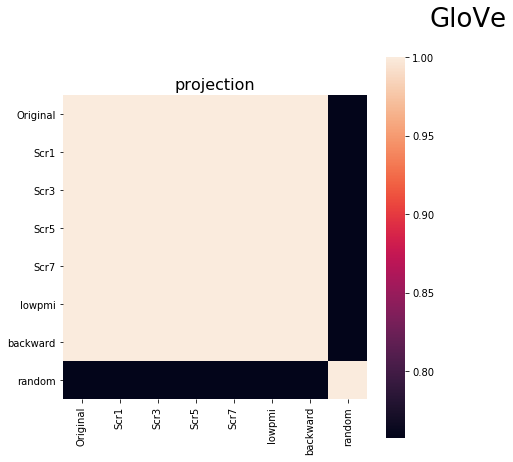

In [58]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")
get_subplots(glove_correlation_dict, "GloVe")

___________________________
___________________________
# CKA

In [59]:
from pathlib import Path

In [60]:
df_distilgpt2

,Original,Scr1,Scr3,Scr5,Scr7,lowpmi,backward,random
0,0.074908,0.086076,-0.098503,0.287310,-0.491648,-0.268378,-0.133161,-0.133560
1,0.433372,0.372021,0.490790,0.501052,0.179898,0.052124,-0.217764,0.831461
2,-1.386395,-0.923225,-1.318906,-1.023111,-1.841627,-0.765052,-1.055040,-1.747107
3,-0.021115,-0.067918,0.020265,0.320247,0.128362,0.136439,-0.139715,-0.122085
4,0.308469,0.072625,0.104190,-0.000543,-0.236029,-0.456595,0.159667,-0.441237
...,...,...,...,...,...,...,...,...
481531,0.419296,0.450490,0.457113,0.323549,0.027656,0.556965,0.155259,0.466709
481532,0.127783,0.127696,0.186835,0.246898,0.319570,0.208378,0.226282,-0.264907
481533,0.345713,0.312569,0.200625,0.350046,-0.075820,0.456372,0.202927,0.071377
481534,-0.232706,-0.095448,0.158781,0.107765,-0.005065,0.058816,-0.066602,-0.081075


In [61]:
(Path(os.path.dirname(os.getcwd())))

PosixPath('/om/user/gretatu')

In [62]:
os.chdir('/om/user/gretatu/CKA-Centered-Kernel-Alignment')

In [63]:
import cca_core
from CKA import linear_CKA, kernel_CKA

In [64]:
dfmatrix_distilgpt2 = main_df_for_plotting("distilgpt2", flatten=False)

  4%|▍         | 178/4368 [00:00<00:02, 1706.73it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 4368/4368 [00:14<00:00, 305.39it/s]


In [65]:
np.shape(dfmatrix_distilgpt2['Original'])

(627, 768)

In [66]:
dfmatrix_distilgpt2_h0 = main_df_for_plotting("distilgpt2", layer_identifier="encoder.h.0", flatten=False)

  4%|▍         | 178/4368 [00:00<00:02, 1751.77it/s]

This is the layer I'm looking at:  encoder.h.0


100%|██████████| 4368/4368 [00:13<00:00, 312.76it/s]


In [67]:
def computeCKA(d, cka_type='linear'):
    labels = []
    
    M = np.zeros((len(d), len(d)))
    r = 0
    for k,v in d.items():
        # print(k)
        c = 0
        for k2,v2 in d.items():
            # print(k2)
            if cka_type == 'linear':
                M[r,c] = linear_CKA(np.asarray(v).T, np.asarray(v2).T)
            c += 1

        r += 1
        
        labels.append(k)
        
    return M, labels

In [68]:
lm1b_correlation_dict = get_correlation_dfs_for_all_layers("lm_1b", flatten=False)

 66%|██████▌   | 2868/4368 [00:00<00:00, 27832.57it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 66%|██████▌   | 2868/4368 [00:00<00:00, 27070.68it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 4368/4368 [00:11<00:00, 388.64it/s]  


In [69]:
distilgpt2_matrix_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2", flatten=False)

  4%|▍         | 178/4368 [00:00<00:02, 1742.34it/s]

This is the layer I'm looking at:  drop


  4%|▍         | 178/4368 [00:00<00:02, 1757.69it/s]

This is the layer I'm looking at:  encoder.h.0


  4%|▍         | 178/4368 [00:00<00:02, 1675.55it/s]

This is the layer I'm looking at:  encoder.h.1


  4%|▍         | 178/4368 [00:00<00:02, 1670.09it/s]

This is the layer I'm looking at:  encoder.h.2


  4%|▍         | 178/4368 [00:00<00:02, 1771.93it/s]

This is the layer I'm looking at:  encoder.h.3


  4%|▍         | 179/4368 [00:00<00:02, 1643.85it/s]

This is the layer I'm looking at:  encoder.h.4


  4%|▍         | 178/4368 [00:00<00:02, 1706.92it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 4368/4368 [00:14<00:00, 307.68it/s]


In [70]:
def get_CKA_subplots(dictionary,model_name):
    number_subplots = len(dictionary)
    number_rows = math.ceil(number_subplots/2)
    
    fig, ax = plt.subplots(number_rows,2, figsize=(15, 7*number_rows))
    ax = ax.flatten()
    fig.suptitle(model_name, fontsize=26)
    
    counter = 0
    for key, value in dictionary.items():
        # Compute CKA for each item
#        print(np.shape(value))
        cka, labels = computeCKA(value)
        print(labels)
        labels = labels[:8]
        ax[counter] = sns.heatmap(cka, ax=ax[counter], square=True, xticklabels=labels, yticklabels=labels)
        ax[counter].set_title(key, fontsize=16)
        bottom, top = ax[counter].get_ylim()
        ax[counter].set_ylim(bottom + 0.5, top - 0.5)
        counter += 1
        
    if number_subplots%2 == 1:
        fig.delaxes(ax[counter])


['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'backward', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'backward', 'random']


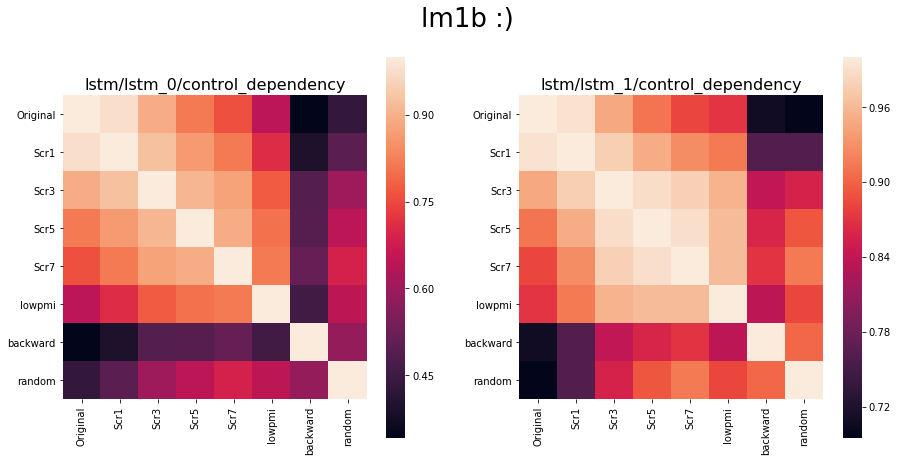

In [71]:
v=get_CKA_subplots(lm1b_correlation_dict, 'lm1b :)')

In [72]:
v